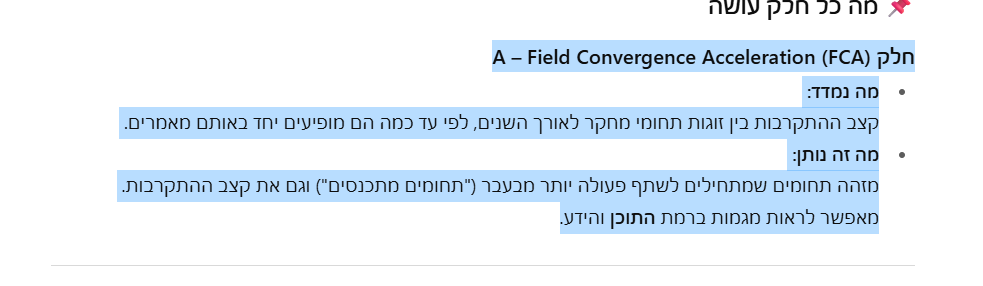

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import json
import math
import itertools
from collections import Counter, defaultdict
from datetime import datetime

import numpy as np
import pandas as pd

###############################################################################
# הגדרות
###############################################################################
YEARS = list(range(2018, 2026))  # 2018–2025 כולל
INPUT_FOLDER_TEMPLATE = "articles_{year}_new"  # בכל שנה יש תיקיה עם all_articles_enhanced.jsonl
INPUT_FILE_NAME = "all_articles_enhanced.jsonl"

# כדי לשלוט בסקלביליות: לקחת רק את Top-K התחומים הנפוצים בכל שנה (None = ללא סילון)
TOP_K_FIELDS_PER_YEAR = 200  # מומלץ 100-300. אפשר לשים None אם רוצים את כולם.

# תיקיית פלט (תתווסף חותמת זמן כדי לא לדרוס הרצה קודמת)
OUTPUT_ROOT = "field_convergence_A"

###############################################################################
# פונקציות עזר
###############################################################################
def read_year_data(year):
    """קורא את קובץ ה-JSONL של אותה שנה ומחזיר רשימת רשומות (dict)."""
    folder = INPUT_FOLDER_TEMPLATE.format(year=year)
    path = os.path.join(folder, INPUT_FILE_NAME)
    if not os.path.exists(path):
        print(f"⚠ קובץ לא נמצא לשנה {year}: {path}")
        return []

    items = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
                items.append(obj)
            except Exception:
                # מסתנן שורות פגומות אם יש
                continue
    return items


def extract_paper_fields(item):
    """מוציא את רשימת התחומים מהפריט (כפי שהוגדר ב-enhance_work_data)."""
    fields = item.get("fields") or []
    # דילול כפילויות/ריקים
    fields = [str(x).strip() for x in fields if x and str(x).strip()]
    # לעבודה לכל מאמר: סט תחומים (למניעת ספירה כפולה של אותו תחום פעמיים באותו מאמר)
    return sorted(set(fields))


def cosine_weight(co_ij, c_i, c_j, eps=1e-12):
    """משקל קישור בין תחומים i,j מבוסס cosine על בסיס ספירות שותפות במאמרים."""
    denom = math.sqrt(max(c_i, 0) * max(c_j, 0)) + eps
    return co_ij / denom


def linear_slope(xs, ys):
    """
    שיפוע קו לינארי (least squares).
    xs: שנים (מספרים)
    ys: משקלים (floats)
    """
    if len(xs) < 2:
        return float("nan"), float("nan")  # לא מספיק נקודות
    slope, intercept = np.polyfit(xs, ys, 1)
    return float(slope), float(intercept)


def ensure_output_dir():
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_dir = f"{OUTPUT_ROOT}_{ts}"
    os.makedirs(out_dir, exist_ok=True)
    return out_dir


###############################################################################
# עיבוד לשנה: ספירות תחומים וזוגות תחומים
###############################################################################
def build_year_field_counts(year_items):
    """
    מחזיר:
      field_count: Counter של הופעות תחום (#מאמרים שמכילים את התחום)
      pair_count: Counter של הופעות זוג תחומים יחד באותו מאמר
    """
    field_count = Counter()
    pair_count = Counter()

    for it in year_items:
        fields = extract_paper_fields(it)
        if len(fields) == 0:
            continue

        # ספירת תחומים (אחד לכל מאמר)
        field_count.update(fields)

        # ספירת זוגות (קומבינציות ללא חזרה)
        if len(fields) > 1:
            for a, b in itertools.combinations(sorted(fields), 2):
                pair_count[(a, b)] += 1

    return field_count, pair_count


def limit_to_top_k(field_count, pair_count, top_k):
    """מסנן לסגמנט של Top-K תחומים לפי שכיחות שנתית כדי לשלוט בסיבוכיות."""
    if top_k is None:
        return field_count, pair_count

    top_fields = set([f for f, _ in field_count.most_common(top_k)])

    # מסנן תחומים
    field_count_limited = Counter({f: c for f, c in field_count.items() if f in top_fields})

    # מסנן זוגות (רק אם שני התחומים בזוג נמצאים ב-Top fields)
    pair_count_limited = Counter({(a, b): c for (a, b), c in pair_count.items()
                                  if a in top_fields and b in top_fields})
    return field_count_limited, pair_count_limited


###############################################################################
# מהלך ראשי
###############################################################################
def main():
    # הכנת תיקיית פלט
    out_dir = ensure_output_dir()

    # לאיסוף כל המשקלים לכל שנה
    rows_weights = []

    # שלב 1: לכל שנה – קוראים, בונים ספירות, מחשבים משקלי cosine לזוגות
    per_year_field_counts = {}
    per_year_pair_counts = {}

    for year in YEARS:
        print(f"➤ מעבד שנה {year} ...")
        items = read_year_data(year)
        if not items:
            print(f"  ⚠ אין נתונים לשנה {year}, מדלג.")
            continue

        field_count, pair_count = build_year_field_counts(items)

        # סינון ל-TopK כדי לשמור על סקלביליות (אופציונלי)
        field_count, pair_count = limit_to_top_k(field_count, pair_count, TOP_K_FIELDS_PER_YEAR)

        per_year_field_counts[year] = field_count
        per_year_pair_counts[year] = pair_count

        # חישוב משקלים לכל זוג
        for (a, b), co_ij in pair_count.items():
            c_i = field_count.get(a, 0)
            c_j = field_count.get(b, 0)
            w = cosine_weight(co_ij, c_i, c_j)
            rows_weights.append({
                "year": year,
                "field_i": a,
                "field_j": b,
                "count_i": c_i,
                "count_j": c_j,
                "coocc": co_ij,
                "weight_cosine": w
            })

    if not rows_weights:
        print("לא נמצאו נתונים לחישוב משקלים. ודאי שהקבצים קיימים במבנה התקיות הנדרש.")
        return

    df_weights = pd.DataFrame(rows_weights)

    # שלב 2: מחשבים FCA (שיפוע לאורך השנים) לכל זוג תחומים שקיים לפחות ב-3 שנים
    fca_rows = []
    # מאחדים זוגות כך ש-(A,B) ~ (B,A) (כבר הוגדר כממויין כאשר יצרנו את הזוגות)
    for (a, b), sub in df_weights.groupby(["field_i", "field_j"]):
        sub = sub.sort_values("year")
        xs = sub["year"].values.astype(float)
        ys = sub["weight_cosine"].values.astype(float)

        if len(sub) < 3:
            # דרישת מינימום לנקודות זמן (אפשר לשנות ל-2 אם רוצים)
            continue

        slope, intercept = linear_slope(xs, ys)

        fca_rows.append({
            "field_i": a,
            "field_j": b,
            "years_covered": len(sub),
            "year_first": int(sub["year"].min()),
            "year_last": int(sub["year"].max()),
            "weight_first": float(sub.iloc[0]["weight_cosine"]),
            "weight_last": float(sub.iloc[-1]["weight_cosine"]),
            "weight_mean": float(sub["weight_cosine"].mean()),
            "FCA_slope": slope,
            "FCA_intercept": intercept
        })

    if not fca_rows:
        print("לא נמצאו זוגות תחומים עם לפחות 3 נקודות זמן. בדוק את הנתונים.")
        return

    df_fca = pd.DataFrame(fca_rows)
    df_top = df_fca.sort_values("FCA_slope", ascending=False).reset_index(drop=True)

    # שלב 3: שמירה לתיקייה
    path_weights = os.path.join(out_dir, "per_year_field_weights.csv")
    path_fca = os.path.join(out_dir, "fca_summary.csv")
    path_top = os.path.join(out_dir, "top_converging_pairs.csv")
    df_weights.to_csv(path_weights, index=False, encoding="utf-8")
    df_fca.to_csv(path_fca, index=False, encoding="utf-8")
    df_top.to_csv(path_top, index=False, encoding="utf-8")

    # README קצר
    # README in English
    readme = f"""Field Convergence Acceleration (Part A)
================================================

Input:
------
For each year in folder: {INPUT_FOLDER_TEMPLATE}  (e.g., articles_2018_new)
File name: {INPUT_FILE_NAME}
Each line is an enriched article JSON object containing the field list ('fields').

What this script does:
----------------------
1) For each year:
   - Counts occurrences of each field (#articles containing the field)
   - Counts co-occurrences of field pairs (appearing in the same article)
   - Computes pairwise connection weight using cosine normalization:
       weight(i,j) = coocc(i,j) / sqrt(count(i) * count(j))

2) Across years:
   - For each field pair, computes a linear regression slope (FCA_slope) of the weight over time.
     This is the "convergence acceleration" metric for that pair.

Output files:
-------------
- per_year_field_weights.csv : All pairwise weights for each year
- fca_summary.csv            : For each pair — FCA_slope, start/end/mean weights, year coverage
- top_converging_pairs.csv   : Sorted by FCA_slope (highest → lowest)

Notes:
------
- You can control complexity via TOP_K_FIELDS_PER_YEAR (default=200).
- To remove filtering and include all fields, set TOP_K_FIELDS_PER_YEAR=None.
- Recommended follow-up: statistical significance testing vs. a degree-preserving random model
  (configuration model), and correlation with impact metrics (citations/citations-per-reference ratio).
"""
    with open(os.path.join(out_dir, "README.txt"), "w", encoding="utf-8") as f:
        f.write(readme)

    with open(os.path.join(out_dir, "README.txt"), "w", encoding="utf-8") as f:
        f.write(readme)

    print("\n✅ הושלם!")
    print(f"- נשמר: {path_weights}")
    print(f"- נשמר: {path_fca}")
    print(f"- נשמר: {path_top}")
    print(f"- תיקיית פלט: {out_dir}")


if __name__ == "__main__":
    main()


➤ מעבד שנה 2018 ...
➤ מעבד שנה 2019 ...
➤ מעבד שנה 2020 ...
➤ מעבד שנה 2021 ...
➤ מעבד שנה 2022 ...
➤ מעבד שנה 2023 ...
➤ מעבד שנה 2024 ...
➤ מעבד שנה 2025 ...

✅ הושלם!
- נשמר: field_convergence_A_20250815_162920/per_year_field_weights.csv
- נשמר: field_convergence_A_20250815_162920/fca_summary.csv
- נשמר: field_convergence_A_20250815_162920/top_converging_pairs.csv
- תיקיית פלט: field_convergence_A_20250815_162920
